# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

/Users/glddm/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/glddm/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/glddm/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <EDCC189C-6D3F-3948-87DF-FA6A06787893> /Users/glddm/miniconda3/envs/py311/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Here I'll create a model like normal, using the same one from my solution for part 4.

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [3]:
model = Classifier()
images, labels = next(iter(testloader)) 

# Get the class probabilities
ps = torch.exp(model(images))
# # Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[0],
        [3],
        [0],
        [0],
        [3],
        [3],
        [3],
        [0],
        [3],
        [3]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [5]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [73]:
def get_accuracy(model, loader, criterion):
    model.eval()
    correct = 0.0
    numImages = 0.0
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in loader:

            log_ps = model(images)
            ps = torch.exp(log_ps)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            correct += torch.sum(equals.type(torch.FloatTensor)).item()
            numImages += float(len(equals))
            
            loss = criterion(log_ps, labels)
            running_loss += loss
    return correct/numImages , running_loss

In [29]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        accuracy , _ = get_accuracy(model, testloader, criterion)
        print(f'Accuracy: {accuracy*100}%')

Accuracy: 82.72%
Accuracy: 85.97%
Accuracy: 86.44%
Accuracy: 85.21%
Accuracy: 87.27000000000001%
Accuracy: 86.65%
Accuracy: 86.92%
Accuracy: 86.42%
Accuracy: 87.32%
Accuracy: 87.77000000000001%
Accuracy: 86.79%
Accuracy: 87.56%
Accuracy: 87.3%
Accuracy: 87.26%
Accuracy: 87.18%
Accuracy: 88.36%
Accuracy: 87.37%
Accuracy: 88.38000000000001%
Accuracy: 87.77000000000001%
Accuracy: 87.94%
Accuracy: 87.85%
Accuracy: 88.31%
Accuracy: 87.57000000000001%
Accuracy: 87.22%
Accuracy: 88.44%
Accuracy: 87.64999999999999%
Accuracy: 88.27000000000001%
Accuracy: 87.88%
Accuracy: 87.97%
Accuracy: 88.31%


## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [48]:
## Define your model with dropout added
class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim = 1)
        
        return x


In [87]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
from tqdm import tqdm

def model_tester(model, loader, criterion):
    accuracy , running_loss= get_accuracy(model, loader, criterion)
    print(f'Testing Accuracy: {accuracy*100}%; testing loss = {running_loss}')
    
    return accuracy, running_loss

def train_model(model, trainloader, testloader, lr = 0.003, epochs = 30, exec_at_each_epoch_fcn = test_model):

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    training_loss_hist, val_loss_hist = [] , [] 
    for e in range(epochs):
        running_loss = 0
    
        for images, labels in tqdm(trainloader):
            model.train()
            
            optimizer.zero_grad()   
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            accuracy , val_loss = model_tester(model, testloader, criterion)
            training_loss_hist.append(running_loss)
            val_loss_hist.append(val_loss)
            

    return model, accuracy, (training_loss_hist, val_loss_hist)



In [89]:
model = FashionClassifier()
model, accuracy, running_loss = train_model(model, trainloader, testloader, epochs= 50)

100%|████████████████████████████████████████| 938/938 [00:02<00:00, 387.02it/s]


Testing Accuracy: 82.61%; testing loss = 73.97566223144531


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 396.26it/s]


Testing Accuracy: 84.15%; testing loss = 68.57178497314453


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 402.87it/s]


Testing Accuracy: 84.41%; testing loss = 65.5688705444336


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.30it/s]


Testing Accuracy: 85.6%; testing loss = 63.826011657714844


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 398.84it/s]


Testing Accuracy: 85.87%; testing loss = 62.70295715332031


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 393.43it/s]


Testing Accuracy: 85.58%; testing loss = 63.07994079589844


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.07it/s]


Testing Accuracy: 85.50999999999999%; testing loss = 62.676395416259766


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 398.77it/s]


Testing Accuracy: 85.92999999999999%; testing loss = 60.99294662475586


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.97it/s]


Testing Accuracy: 86.11%; testing loss = 59.94921875


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 402.27it/s]


Testing Accuracy: 86.35000000000001%; testing loss = 59.15505599975586


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 398.87it/s]


Testing Accuracy: 86.61%; testing loss = 59.00914764404297


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.47it/s]


Testing Accuracy: 86.61%; testing loss = 59.1702995300293


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.50it/s]


Testing Accuracy: 86.47%; testing loss = 58.2724494934082


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.88it/s]


Testing Accuracy: 87.36%; testing loss = 58.2096061706543


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 403.90it/s]


Testing Accuracy: 86.71%; testing loss = 58.517337799072266


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.29it/s]


Testing Accuracy: 86.56%; testing loss = 58.70490646362305


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.76it/s]


Testing Accuracy: 86.72%; testing loss = 57.559791564941406


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.73it/s]


Testing Accuracy: 86.68%; testing loss = 57.31706237792969


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 397.99it/s]


Testing Accuracy: 86.7%; testing loss = 58.356929779052734


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.70it/s]


Testing Accuracy: 86.50999999999999%; testing loss = 60.36445236206055


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 395.55it/s]


Testing Accuracy: 87.75%; testing loss = 56.53706359863281


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 406.20it/s]


Testing Accuracy: 86.9%; testing loss = 57.273983001708984


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 398.64it/s]


Testing Accuracy: 87.01%; testing loss = 57.42364501953125


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.41it/s]


Testing Accuracy: 86.97%; testing loss = 58.436038970947266


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.51it/s]


Testing Accuracy: 87.09%; testing loss = 59.19667434692383


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 407.07it/s]


Testing Accuracy: 87.39%; testing loss = 59.10559844970703


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.35it/s]


Testing Accuracy: 87.44%; testing loss = 57.48798370361328


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 402.30it/s]


Testing Accuracy: 87.02%; testing loss = 58.02121353149414


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.32it/s]


Testing Accuracy: 87.51%; testing loss = 56.5606575012207


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 403.69it/s]


Testing Accuracy: 86.61%; testing loss = 59.12796401977539


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.00it/s]


Testing Accuracy: 87.79%; testing loss = 55.35512924194336


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.38it/s]


Testing Accuracy: 87.57000000000001%; testing loss = 58.28916931152344


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 396.86it/s]


Testing Accuracy: 87.22%; testing loss = 57.70460891723633


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.80it/s]


Testing Accuracy: 86.75%; testing loss = 57.267417907714844


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.25it/s]


Testing Accuracy: 87.45%; testing loss = 57.53218460083008


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.15it/s]


Testing Accuracy: 87.4%; testing loss = 57.65380859375


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.60it/s]


Testing Accuracy: 87.33%; testing loss = 56.870365142822266


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 395.88it/s]


Testing Accuracy: 87.44%; testing loss = 57.356109619140625


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 400.59it/s]


Testing Accuracy: 87.2%; testing loss = 57.85935974121094


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.69it/s]


Testing Accuracy: 86.72%; testing loss = 60.04062271118164


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.21it/s]


Testing Accuracy: 87.18%; testing loss = 57.427303314208984


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.76it/s]


Testing Accuracy: 87.26%; testing loss = 60.27028274536133


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 396.94it/s]


Testing Accuracy: 87.58%; testing loss = 58.87840270996094


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 397.35it/s]


Testing Accuracy: 87.35000000000001%; testing loss = 56.5586051940918


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 404.81it/s]


Testing Accuracy: 87.77000000000001%; testing loss = 55.883636474609375


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 399.29it/s]


Testing Accuracy: 87.58%; testing loss = 56.544376373291016


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 395.60it/s]


Testing Accuracy: 87.27000000000001%; testing loss = 58.047855377197266


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 401.90it/s]


Testing Accuracy: 87.39%; testing loss = 59.14656066894531


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 387.58it/s]


Testing Accuracy: 87.03999999999999%; testing loss = 59.66522216796875


100%|████████████████████████████████████████| 938/938 [00:02<00:00, 395.23it/s]


Testing Accuracy: 87.83%; testing loss = 61.05575942993164


In [113]:
%matplotlib inline
import numpy as np

In [114]:
import matplotlib.pyplot as plt
training_loss_hist, val_loss_hist = running_loss
training_loss_hist = np.array(training_loss_hist)
training_loss_hist /= 6.0

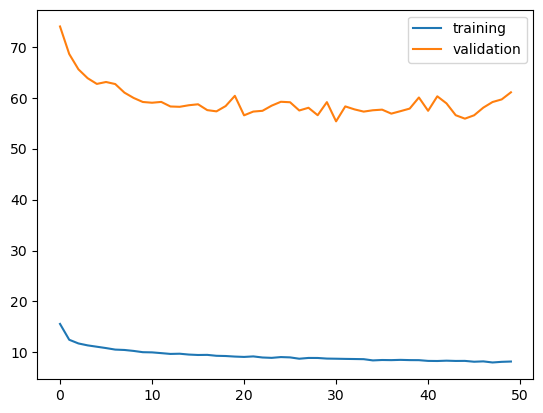

In [115]:
plt.plot(training_loss_hist / 6.0, label = 'training')
plt.plot(val_loss_hist, label ='validation')
plt.legend()
plt.show()



## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

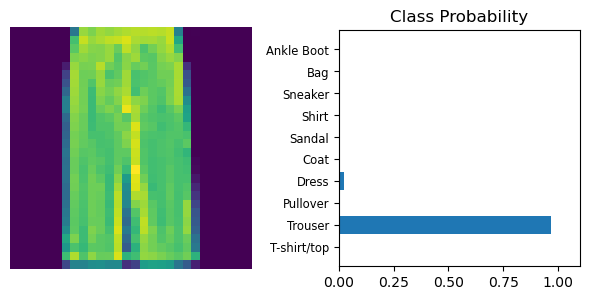

In [117]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.